In [95]:
# Load data set and target values
import sys
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/Preprocess')
sys.path.append('/home/peng/git/Machine_learning_for_reliability_analysis/DAlgorithms')

import Preprocessdata
import RFclass

from __future__ import print_function
from __future__ import division

import logging
from sklearn.datasets import make_classification
from sklearn.cross_validation import cross_val_score

from sklearn.ensemble import RandomForestClassifier as RFC


from bayes_opt import BayesianOptimization
from pandas.core.frame import DataFrame
import numpy as np
import pandas as pd


p= Preprocessdata.standardprocess()


save_path = '/home/peng/Documents/Project_C/Turbofan/Dataset/'

results_path = '/home/peng/git/Machine_learning_for_reliability_analysis/RA_Risk/results/'
#names = xrange(0,28)

df = pd.read_csv(save_path + 'train_FD001_2_p20_.txt', header=0)

#df = pd.read_csv(save_path + 'train_FD001_2_disc.txt', header=0)
#df = df.sample(n=10000)
rad_stat = 2
seed = 'rf'

# drop the first column
df = df.drop(df.columns[[0]], axis=1)

#print (df)

#### scale the training dataset first and then apply the rules to test set 
#train, trainlabel, test, testlabel = p.sep_scale_divd(df, 0.7)
train, trainlabel, test, testlabel = p.scaledivd(df, 1.0)
#print (test[0:10])


In [157]:
print (np.mean(testlabel))

0.510600071865


In [96]:
test = train
testlabel = trainlabel

In [97]:
# Variational autoencoder

'''This script demonstrates how to build a variational autoencoder with Keras.
Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
import timeit


start = timeit.default_timer()

#batch_size = 100
original_dim = 24
latent_dim = 2
intermediate_dim = 12
nb_epoch = 15

x = Input(shape=(24,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(latent_dim, ), mean=0.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

vae.fit(train, train,
        shuffle=True,
        nb_epoch=nb_epoch,
        #batch_size=batch_size,
        verbose = 0)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space

train_encoded = encoder.predict(train)
#print(np.shape(train)[1])
test_encoded = encoder.predict(test)
#print(np.shape(test))

encoded_dim = np.shape(train_encoded)[1]

stop = timeit.default_timer()

print ("The running takes %r min" %((stop-start)/60))

The running takes 0.07569263378779094 min


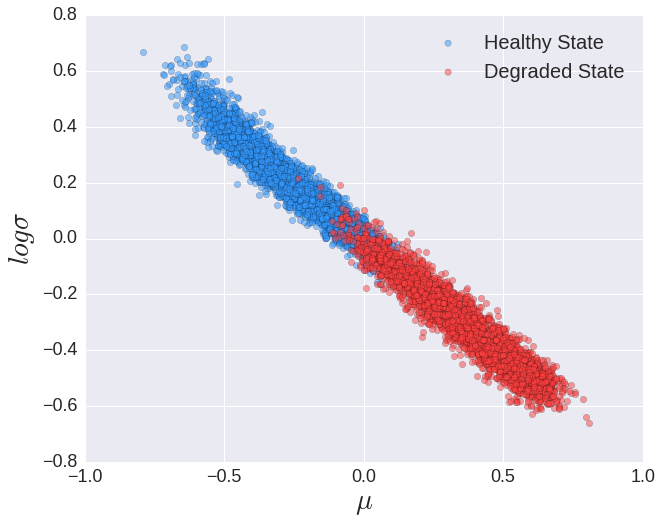

In [98]:
df_label = pd.DataFrame({'mean': test_encoded[:,0], 'std': test_encoded[:, 1], 'label': testlabel})

#print (df_label)
import seaborn as sns
from pylab import *

plt.figure(figsize=(10, 8), dpi=1200)

plt.scatter(df_label[df_label['label']==0]['mean'], df_label[df_label['label']==0]['std'], c= '#3399ff', alpha=0.5, 
            label = 'Healthy State',s = 40)
#plt.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'], c= 'y', alpha=0.5)

plt.scatter(df_label[df_label['label']==1]['mean'], df_label[df_label['label']==1]['std'],
            c= '#ff4040', alpha=0.5, label = 'Degraded State', s = 40)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('$\mu$',fontsize = 28)
plt.ylabel('$log\sigma$',fontsize = 28)

plt.legend(fontsize = 20)
savefig(results_path + 'exercice_2.eps',dpi=1200)
plt.show()

In [99]:
df_label.to_csv(results_path+'vae_2plots_all.csv', header = True)

In [100]:
df_label_11 = pd.DataFrame({'mean': test_encoded[:,0], 'std': test_encoded[:, 1], 'label': testlabel})

df_label_2 = df_label_11

df_label_22 = df_label_2.drop(df_label_2.columns[[0]], axis=1)

#print (df_label_22)


          mean       std
0     0.340230 -0.335793
1    -0.373079  0.156282
2    -0.229031  0.155021
3    -0.317888  0.285589
4    -0.271495  0.184154
5     0.079491 -0.054369
6     0.034456  0.023750
7     0.559074 -0.529208
8     0.164856 -0.134115
9     0.011041 -0.100847
10    0.298806 -0.260158
11   -0.495031  0.401974
12    0.270389 -0.235199
13   -0.436612  0.326046
14   -0.308856  0.243089
15   -0.476664  0.368955
16   -0.330498  0.225155
17    0.421142 -0.393673
18   -0.108580  0.029702
19    0.342124 -0.313476
20    0.265184 -0.221433
21    0.498921 -0.471766
22    0.031820 -0.024755
23   -0.042501  0.003791
24    0.095789 -0.074193
25    0.052918 -0.087002
26    0.200774 -0.185303
27    0.155052 -0.168308
28   -0.319879  0.230170
29    0.088716 -0.082582
...        ...       ...
8319 -0.085968  0.070486
8320  0.482077 -0.457576
8321  0.355593 -0.295896
8322 -0.505571  0.525980
8323 -0.210280  0.120053
8324 -0.421074  0.443278
8325 -0.296608  0.194949
8326 -0.412046  0.258501


In [101]:
output_label = np.array(df_label_2['label'])
output_label_1 = output_label
#output_label_1 = ((output_label /2)-1)*(-1)
print (output_label_1[0:20])

[ 1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  0.  1.  0.  0.  0.  0.  1.
  0.  1.]


In [102]:
df_label_1 = pd.DataFrame({'mean': test_encoded[:,0], 'std': test_encoded[:, 1]})


train_kmm = np.array(df_label_22)

print (train_kmm)


[[ 0.34023005 -0.33579296]
 [-0.37307882  0.1562824 ]
 [-0.22903137  0.15502106]
 ..., 
 [ 0.47118059 -0.42976087]
 [-0.07402052  0.11790445]
 [-0.12544391  0.1506644 ]]


In [103]:
from sklearn.cluster import KMeans

n_num = 2

k_means = KMeans(init='k-means++', n_clusters=n_num, n_init=10)
X = train_kmm
k_means.fit(train_kmm)

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)



In [159]:
print (np.shape(train_kmm))
print (k_means_labels[0:10])
print (df_label_2['label'][0:10])

from sklearn.metrics.classification import accuracy_score, confusion_matrix, classification_report

print (confusion_matrix(k_means_labels,output_label_1))
print( classification_report(k_means_labels, output_label_1))
print (accuracy_score(k_means_labels,output_label_1))

(8349, 2)
[1 0 0 0 0 1 0 1 1 0]
0    1.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    1.0
8    1.0
9    1.0
Name: label, dtype: float64
[[4041  185]
 [  45 4078]]
             precision    recall  f1-score   support

          0       0.99      0.96      0.97      4226
          1       0.96      0.99      0.97      4123

avg / total       0.97      0.97      0.97      8349

0.972451790634


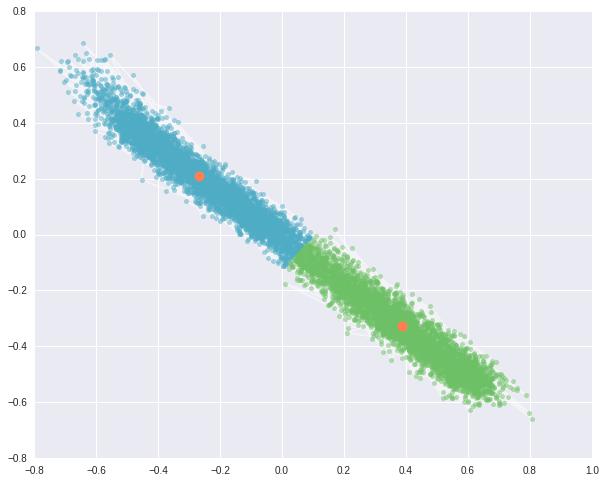

In [156]:
fig = plt.figure(figsize=(10, 8))
n_clusters = 2
colors = ['#4EACC5', '#6dc066']
col_center = ['r', 'b']

# KMeans

for k, col in zip(range(n_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.', alpha =0.5, markersize=10)

    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor= '#ff7f50', markeredgecolor='#000000', 
             markersize=10)




plt.show()